# Denoising Diffusion Probabilistic Models, CIFAR-10 dataset

In this notebook, we use the models, training and sampling code built out during the ddpm_mnist notebook to train a DDPM model on the CIFAR-10 dataset.

In [26]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# we already built out the UNet in the previous notebook
# so we import it from the src folder
from src.unet import UNet
from src.ddpm import train_model, sample_images
from src.utils import count_parameters

In [27]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip()
])

cifar10_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
train_dataset, val_dataset = random_split(cifar10_full, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_loader = [(x.to(device), y.to(device)) for x, y in train_loader]
val_loader = [(x.to(device), y.to(device)) for x, y in val_loader]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Files already downloaded and verified
Train dataset size: 45000
Validation dataset size: 5000
Number of training batches: 352
Number of validation batches: 40


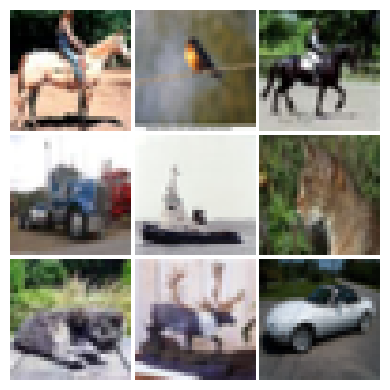

In [29]:

fig, axes = plt.subplots(3, 3, figsize=(4, 4))

for i in range(9):
    img, _ = train_dataset[i]
    row = i // 3
    col = i % 3
    
    img = img * 0.5 + 0.5  
    img = img.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

In [30]:
model = UNet(
    down_filters=[128, 256, 256, 256], 
    in_channels=3, 
    num_layers=2, 
    has_attention=[False, True, False, False], 
    num_heads=4, 
    diffusion_steps=1000,
    num_groups=8, 
    activation=nn.SiLU, 
    dropout=0.1
).to(device)

print(f"The UNet model has {count_parameters(model):,} trainable parameters.")

The UNet model has 44,391,183 trainable parameters.


In [31]:
lr = 1e-4
epochs = 100

optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=500, T_mult=2)
data_loaders = {'train': train_loader, 'valid': val_loader}
loss_fn = nn.MSELoss()
beta_schedule = torch.linspace(0.0001, 0.02, 1000).to(device)

train_loss, valid_loss = train_model(
    model=model,
    loaders=data_loaders,
    epochs=epochs,
    optim=optim,
    loss_fn=loss_fn,
    beta_schedule=beta_schedule,
    scheduler=scheduler,
    per_step_scheduler=True,
    checkpoint_every=10,
    checkpoint_name_prefix='ddpm_cifar_68M_1e_4'
)


Epoch 0 of 100


In [23]:
sampled_images = sample_images(model, beta_schedule, 1000, device, image_shape=(3, 32, 32), num_samples=16)
sampled_images_cpu = sampled_images.cpu()

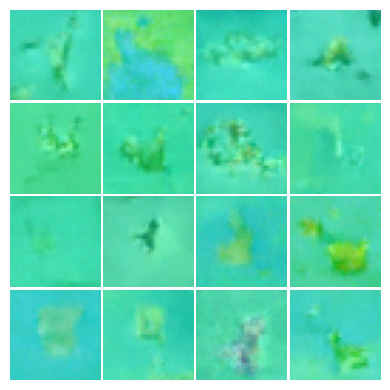

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(4, 4))

for i in range(16):
    img = sampled_images_cpu[i]
    row = i // 4
    col = i % 4
    
    img = img * 0.5 + 0.5  
    img = img.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

In [25]:
# Calculate and print means and variances of pixels in the sampled images
means = sampled_images_cpu.mean(dim=(0, 2, 3))
variances = sampled_images_cpu.var(dim=(0, 2, 3))

print("Pixel means for each channel:")
print(f"Red: {means[0]:.4f}")
print(f"Green: {means[1]:.4f}")
print(f"Blue: {means[2]:.4f}")

print("\nPixel variances for each channel:")
print(f"Red: {variances[0]:.4f}")
print(f"Green: {variances[1]:.4f}")
print(f"Blue: {variances[2]:.4f}")

# Calculate and print overall mean and variance
overall_mean = sampled_images_cpu.mean()
overall_variance = sampled_images_cpu.var()

print(f"\nOverall mean: {overall_mean:.4f}")
print(f"Overall variance: {overall_variance:.4f}")



Pixel means for each channel:
Red: -0.4484
Green: 0.6678
Blue: 0.3198

Pixel variances for each channel:
Red: 0.0185
Green: 0.0069
Blue: 0.0346

Overall mean: 0.1797
Overall variance: 0.2375
